# Practice Gridsearch and Multinomial Models with SF Crime Data


---

### Multinomial logistic regression models

So far, we have been using logistic regression for binary problems where there are only two class labels. Logistic regression can be extended to dependent variables with multiple classes.

There are two ways sklearn solves multiple-class problems with logistic regression: a multinomial loss or a "one vs. rest" (OvR) process where a model is fit for each target class vs. all the other classes. 

**Multinomial vs. OvR**
- (M) 'k-1' models with 1 reference category
- (OvR) 'k*(k-1)/2' models

You will use the gridsearch in conjunction with multinomial logistic to optimize a model that predicts the category (type) of crime based on various features captured by San Francisco police departments.

**Necessary lab imports**

In [147]:
import numpy as np
import pandas as pd
import patsy

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Read in the data

In [149]:
crime_csv = r"C:\Users\saads\Desktop\Data science\my project\mini project 3\sf_crime_train.csv"

In [150]:
#read in the data using pandas
sf_crime = pd.read_csv(crime_csv)
sf_crime.drop('DayOfWeek',axis=1,inplace=True)
sf_crime.head()

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y
0,5/13/15 23:53,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,5/13/15 23:53,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,5/13/15 23:33,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,5/13/15 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,5/13/15 23:30,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [151]:
# check the shape of your dataframe

print(sf_crime.shape)


(18000, 8)


In [152]:
#check whether there are any missing values
#do we need to fix anything here?

# Check for missing values in the DataFrame
missing_values = sf_crime.isnull().sum()

# Display the missing values
print(missing_values)


Dates         0
Category      0
Descript      0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64


In [160]:
#check what your datatypes are
#do we need to fix anything here?

print(sf_crime.dtypes)

Dates          datetime64[ns]
Category               object
Descript               object
PdDistrict             object
Resolution             object
Address                object
X                     float64
Y                     float64
Year                    int32
Month                   int32
Day_of_Week             int32
Hour                    int32
Time                   object
Date                   object
dtype: object


### 2. Create column for year, month, day, hour, time, and date from 'Dates' column.

> *`pd.to_datetime` and `Series.dt` may be helpful here!*


In [162]:
# convert the 'Dates' column to a datetime object
sf_crime['Dates'] = pd.to_datetime(sf_crime['Dates'])

In [157]:
# create a new column for 'Year','Month',and 'Day_of_Week'
sf_crime['Year'] = sf_crime['Dates'].dt.year
sf_crime['Month'] = sf_crime['Dates'].dt.month
sf_crime['Day_of_Week'] = sf_crime['Dates'].dt.dayofweek
#check the first couple rows to make sure it's what you want


In [158]:
# create a column for the 'Hour','Time', and 'Date'
sf_crime['Hour'] = sf_crime['Dates'].dt.hour
sf_crime['Time'] = sf_crime['Dates'].dt.time
sf_crime['Date'] = sf_crime['Dates'].dt.date

sf_crime.head(2)

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2,23,23:53:00,2015-05-13
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2,23,23:53:00,2015-05-13


In [109]:
# Drop the 'Dates' column
sf_crime.drop('Dates',axis=1,inplace=True)

sf_crime.head(2)

,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date
0,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2,23,23:53:00,2015-05-13
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2,23,23:53:00,2015-05-13


### 3. Validate and clean the data.

In [110]:
# check the 'Category' value counts to see what sort of categories there are
# and to see if anything might require cleaning (particularly the ones with fewer values)
category_counts = sf_crime['Category'].value_counts()
print(category_counts)

Category
LARCENY/THEFT                  4885
OTHER OFFENSES                 2291
NON-CRIMINAL                   2255
ASSAULT                        1536
VEHICLE THEFT                   967
VANDALISM                       877
BURGLARY                        732
WARRANTS                        728
SUSPICIOUS OCC                  592
MISSING PERSON                  535
DRUG/NARCOTIC                   496
ROBBERY                         465
FRAUD                           363
SECONDARY CODES                 261
WEAPON LAWS                     212
TRESPASS                        130
STOLEN PROPERTY                 111
SEX OFFENSES FORCIBLE           103
FORGERY/COUNTERFEITING           85
DRUNKENNESS                      74
KIDNAPPING                       50
PROSTITUTION                     44
DRIVING UNDER THE INFLUENCE      42
DISORDERLY CONDUCT               37
ARSON                            35
LIQUOR LAWS                      25
RUNAWAY                          16
BRIBERY            

In [111]:
# What's going on with 'TRESPASS' and 'TRESPASSING'?
# What's going on with 'ASSAULT' and 'ASSUALT'?
# fix these with .loc
sf_crime.loc[sf_crime['Category'] == 'ASSUALT', 'Category'] = 'ASSAULT'
sf_crime.loc[sf_crime['Category'] == 'TRESPASSING', 'Category'] = 'TRESPASS'


category_counts_cleaned = sf_crime['Category'].value_counts()
print(category_counts_cleaned)

Category
LARCENY/THEFT                  4885
OTHER OFFENSES                 2291
NON-CRIMINAL                   2255
ASSAULT                        1538
VEHICLE THEFT                   967
VANDALISM                       877
BURGLARY                        732
WARRANTS                        728
SUSPICIOUS OCC                  592
MISSING PERSON                  535
DRUG/NARCOTIC                   496
ROBBERY                         465
FRAUD                           363
SECONDARY CODES                 261
WEAPON LAWS                     212
TRESPASS                        131
STOLEN PROPERTY                 111
SEX OFFENSES FORCIBLE           103
FORGERY/COUNTERFEITING           85
DRUNKENNESS                      74
KIDNAPPING                       50
PROSTITUTION                     44
DRIVING UNDER THE INFLUENCE      42
DISORDERLY CONDUCT               37
ARSON                            35
LIQUOR LAWS                      25
RUNAWAY                          16
BRIBERY            

In [112]:
# have a look to see whether you have all the days of the week in your data

days_of_week_counts = sf_crime['Day_of_Week'].value_counts().sort_index()
print(days_of_week_counts)



Day_of_Week
0    2447
1    2399
2    2930
3    2479
4    2733
5    2556
6    2456
Name: count, dtype: int64


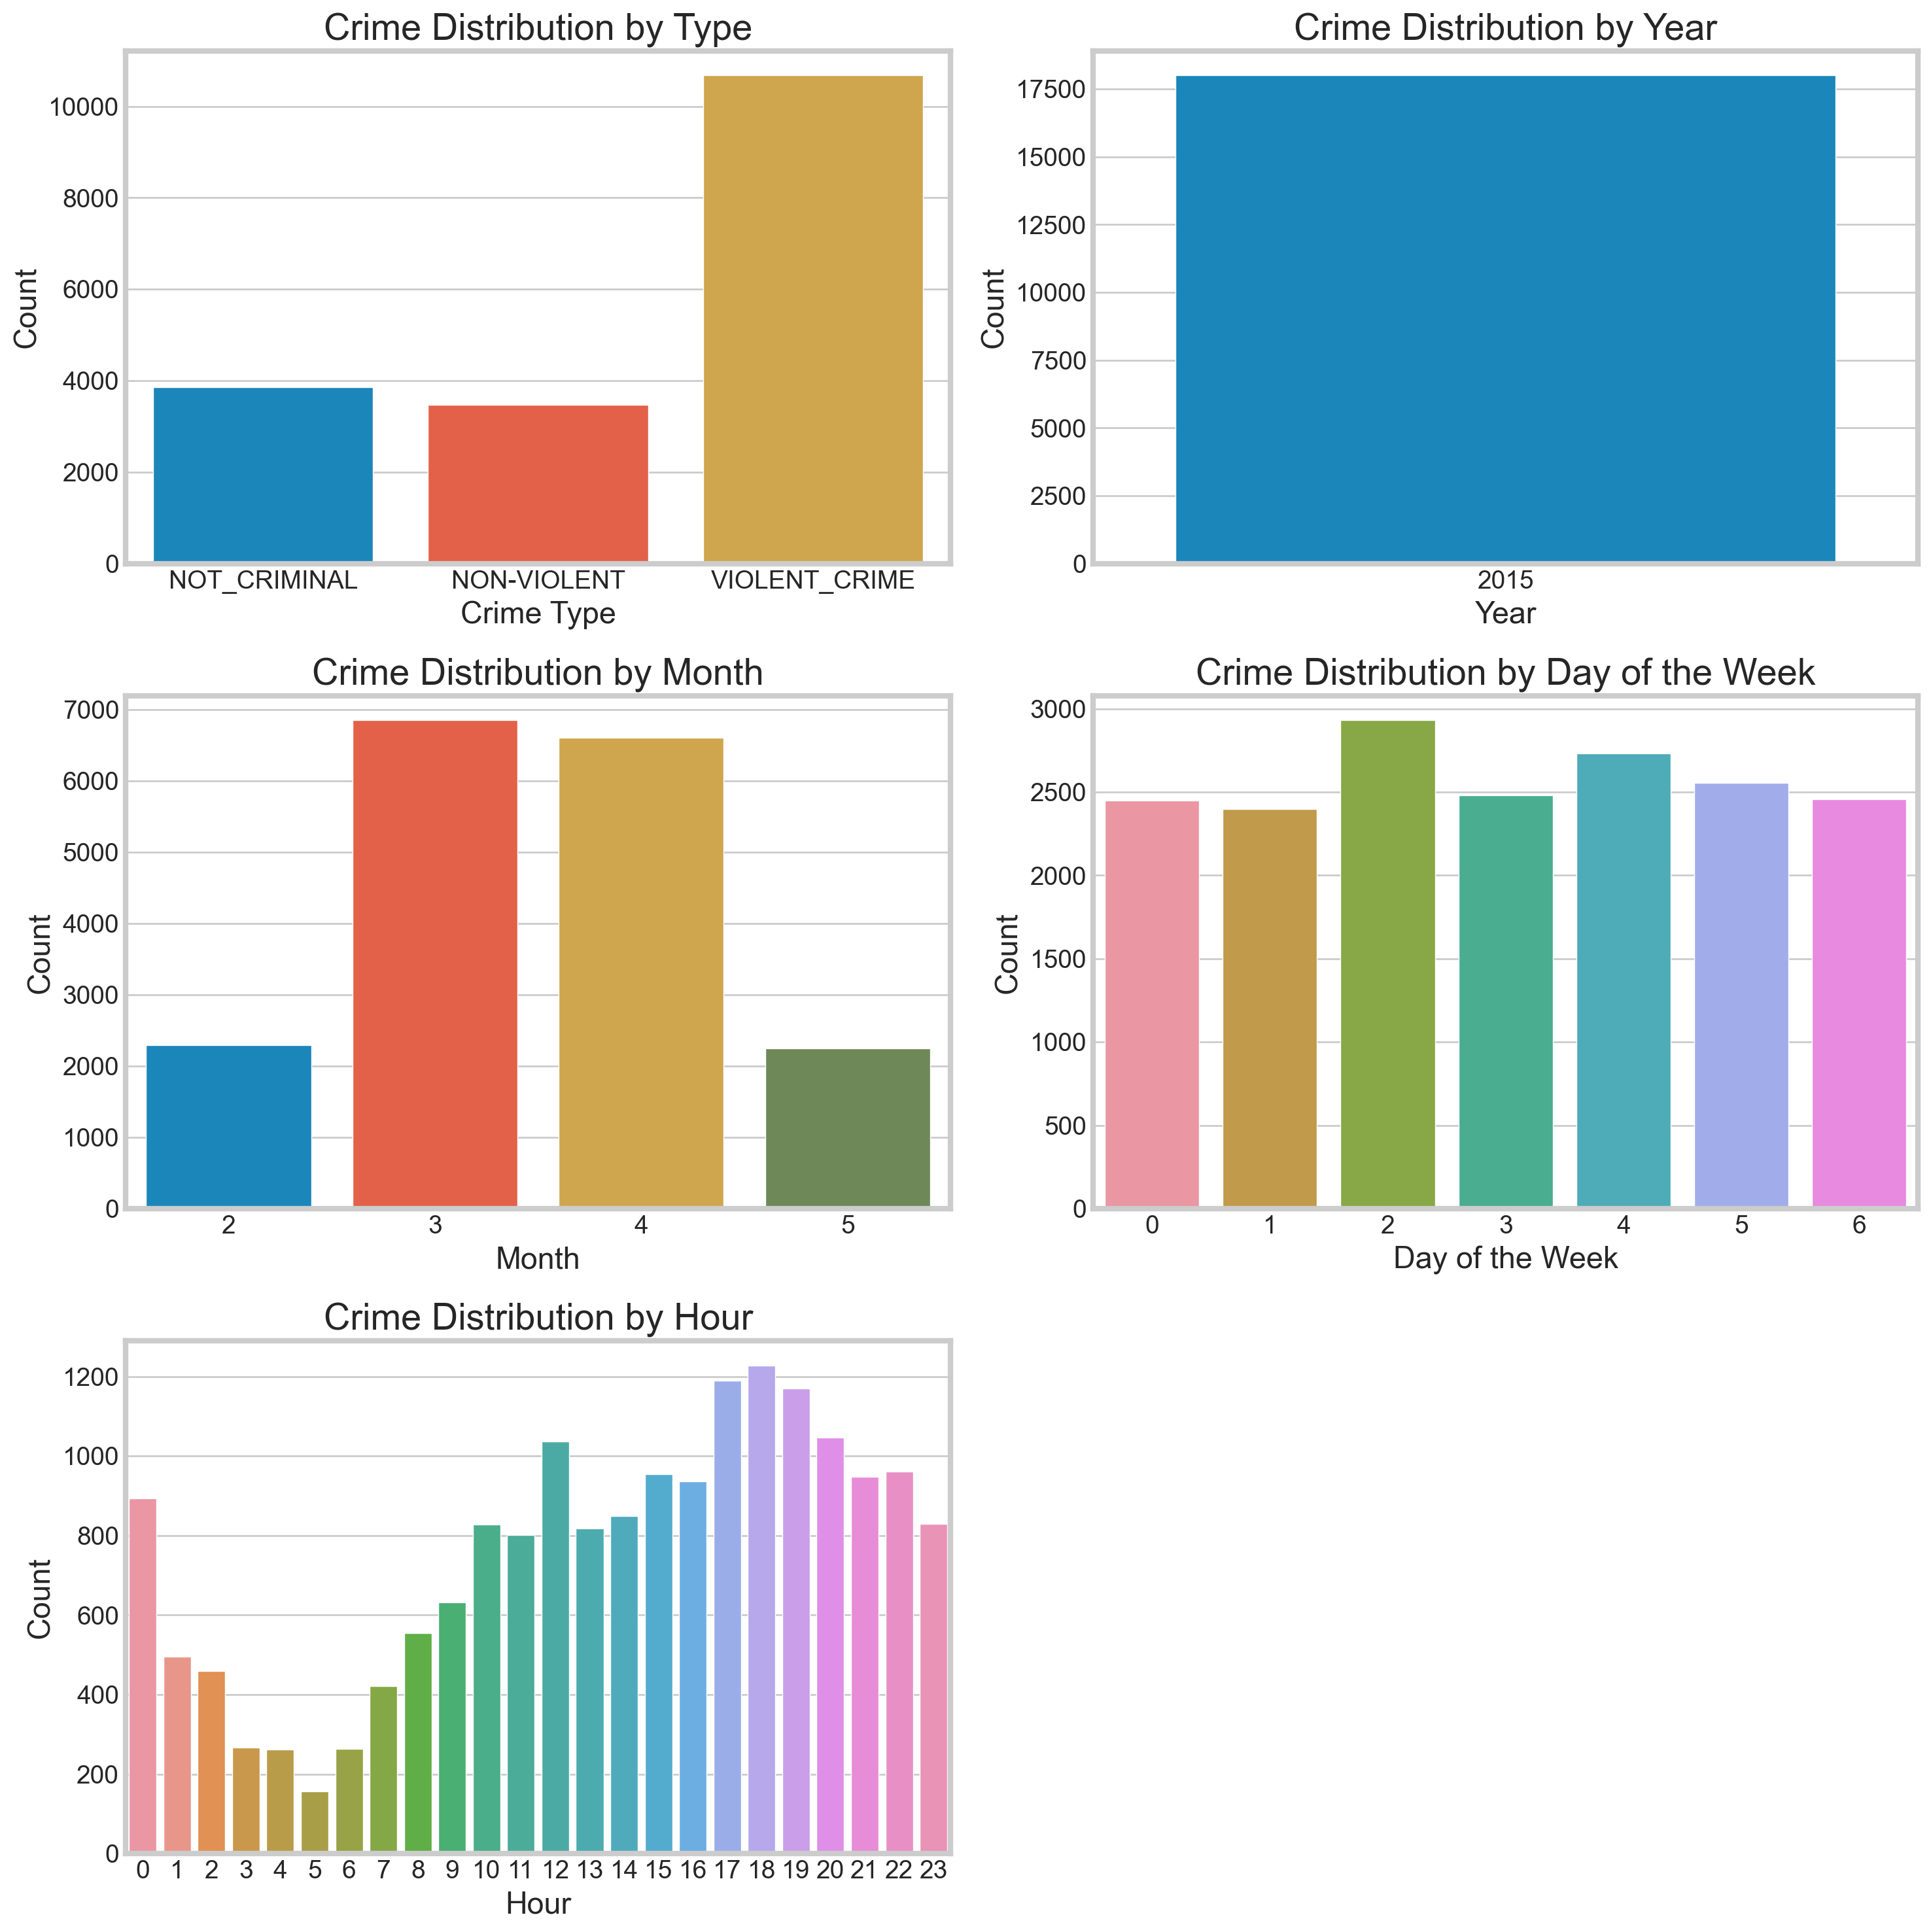

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and axis for each plot
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot crime distribution by Type
sns.countplot(x='Type', data=sf_crime, ax=axes[0, 0])
axes[0, 0].set_title('Crime Distribution by Type')
axes[0, 0].set_xlabel('Crime Type')
axes[0, 0].set_ylabel('Count')

# Plot crime distribution by Year
sns.countplot(x='Year', data=sf_crime, ax=axes[0, 1])
axes[0, 1].set_title('Crime Distribution by Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Count')

# Plot crime distribution by Month
sns.countplot(x='Month', data=sf_crime, ax=axes[1, 0])
axes[1, 0].set_title('Crime Distribution by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Count')

# Plot crime distribution by Day of the Week
sns.countplot(x='Day_of_Week', data=sf_crime, ax=axes[1, 1])
axes[1, 1].set_title('Crime Distribution by Day of the Week')
axes[1, 1].set_xlabel('Day of the Week')
axes[1, 1].set_ylabel('Count')

# Plot crime distribution by Hour
sns.countplot(x='Hour', data=sf_crime, ax=axes[2, 0])
axes[2, 0].set_title('Crime Distribution by Hour')
axes[2, 0].set_xlabel('Hour')
axes[2, 0].set_ylabel('Count')

# Remove the unused subplot (bottom right)
fig.delaxes(axes[2, 1])

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()


In [113]:
# have a look at the value counts for 'Descript', 'PdDistrict', and 'Resolution' to make sure it all checks out

# Check the value counts for 'Descript'
descript_counts = sf_crime['Descript'].value_counts()
print("Descript value counts:")
print(descript_counts)

# Check the value counts for 'PdDistrict'
pddistrict_counts = sf_crime['PdDistrict'].value_counts()
print("\nPdDistrict value counts:")
print(pddistrict_counts)

# Check the value counts for 'Resolution'
resolution_counts = sf_crime['Resolution'].value_counts()
print("\nResolution value counts:")
print(resolution_counts)

Descript value counts:
Descript
GRAND THEFT FROM LOCKED AUTO                    2127
STOLEN AUTOMOBILE                                625
AIDED CASE, MENTAL DISTURBED                     591
DRIVERS LICENSE, SUSPENDED OR REVOKED            589
BATTERY                                          520
                                                ... 
SALE OF OPIUM                                      1
PHONE CALLS IN VIOLATION OF DV COURT ORDER         1
EMBEZZLEMENT, GRAND THEFT BY BROOKERS/AGENTS       1
TRANSPORTAION OF CONTROLLED SUBSTANCE              1
ROBBERY OF A RESIDENCE WITH A GUN                  1
Name: count, Length: 510, dtype: int64

PdDistrict value counts:
PdDistrict
SOUTHERN      3287
NORTHERN      2250
CENTRAL       2206
MISSION       2118
BAYVIEW       1678
INGLESIDE     1628
TARAVAL       1426
TENDERLOIN    1327
RICHMOND      1101
PARK           979
Name: count, dtype: int64

Resolution value counts:
Resolution
NONE                                      12862
ARREST, 

In [114]:
# use .describe() to see whether the location coordinates seem appropriate
location_description = sf_crime[['X', 'Y']].describe()
print(location_description)

                  X             Y
count  18000.000000  18000.000000
mean    -122.423639     37.768466
std        0.026532      0.024391
min     -122.513642     37.708154
25%     -122.434199     37.753838
50%     -122.416949     37.775608
75%     -122.406539     37.785390
max     -122.365565     37.819923


### 4. Set up a target and predictor matrix for predicting violent crime vs. non-violent crime vs. non-crimes.

**Non-Violent Crimes:**
- bad checks
- bribery
- drug/narcotic
- drunkenness
- embezzlement
- forgery/counterfeiting
- fraud
- gambling
- liquor
- loitering 
- trespass

**Non-Crimes:**
- non-criminal
- runaway
- secondary codes
- suspicious occ
- warrants

**Violent Crimes:**
- everything else



**What type of model do you need here? What is your baseline accuracy?**

In [115]:
NVC = ['BAD CHECKS','BRIBERY','DRUG/NARCOTIC','DRUNKENNESS',
     'EMBEZZLEMENT','FORGERY/COUNTERFEITING','FRAUD',
     'GAMBLING','LIQUOR','LOITERING','TRESPASS','OTHER OFFENSES']

NOT_C = ['NON-CRIMINAL','RUNAWAY','SECONDARY CODES','SUSPICIOUS OCC','WARRANTS']

#use a list comprehension to get all the categories in sf_crime['Category'].unique() that are NOT in the lists above
all_categories = sf_crime['Category'].unique()

VC = [category for category in all_categories if category not in NVC and category not in NOT_C]

In [164]:
#add a column called 'Type' into your dataframe that stores whether the observation was:
#Non-Violent, Violent, or Non-Crime
#use .map()!
def typecrime(x):
    if x in NOT_C: return 'NOT_CRIMINAL'
    if x in NVC: return 'NON-VIOLENT'
    if x in VC: return 'VIOLENT_CRIME'

sf_crime['Type']=sf_crime['Category'].map(typecrime)

sf_crime.head(5)

,Dates,Category,Descript,PdDistrict,Resolution,Address,X,Y,Year,Month,Day_of_Week,Hour,Time,Date,Type
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2,23,23:53:00,2015-05-13,NOT_CRIMINAL
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,2,23,23:53:00,2015-05-13,NON-VIOLENT
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,2,23,23:33:00,2015-05-13,NON-VIOLENT
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,2,23,23:30:00,2015-05-13,VIOLENT_CRIME
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,2,23,23:30:00,2015-05-13,VIOLENT_CRIME


In [117]:
#find the baseline accuracy:
baseline_accuracy = sf_crime['Type'].value_counts(normalize=True).max()
print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 59.31%


In [118]:
#create a target array with 'Type'
y = sf_crime['Type']

#create a predictor matrix with 'Day_of_Week','Month','Year','PdDistrict','Hour', and 'Resolution'
X = sf_crime[['Day_of_Week', 'Month', 'Year', 'PdDistrict', 'Hour', 'Resolution']]

print(y.head())
print(X.head())

0     NOT_CRIMINAL
1      NON-VIOLENT
2      NON-VIOLENT
3    VIOLENT_CRIME
4    VIOLENT_CRIME
Name: Type, dtype: object
   Day_of_Week  Month  Year PdDistrict  Hour      Resolution
0            2      5  2015   NORTHERN    23  ARREST, BOOKED
1            2      5  2015   NORTHERN    23  ARREST, BOOKED
2            2      5  2015   NORTHERN    23  ARREST, BOOKED
3            2      5  2015   NORTHERN    23            NONE
4            2      5  2015       PARK    23            NONE


In [119]:
#use pd.get_dummies() to dummify your categorical variables
#remember to drop a column!
print("Columns before dummification:", X.columns)

# Use pd.get_dummies() to dummify the categorical variables and drop the first column to avoid multicollinearity
X = pd.get_dummies(X, columns=['PdDistrict', 'Resolution'], drop_first=True)

# Check the column names after dummification to ensure all columns are numeric
print("Columns after dummification:", X.columns)


Columns before dummification: Index(['Day_of_Week', 'Month', 'Year', 'PdDistrict', 'Hour', 'Resolution'], dtype='object')
Columns after dummification: Index(['Day_of_Week', 'Month', 'Year', 'Hour', 'PdDistrict_CENTRAL',
       'PdDistrict_INGLESIDE', 'PdDistrict_MISSION', 'PdDistrict_NORTHERN',
       'PdDistrict_PARK', 'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN',
       'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN',
       'Resolution_ARREST, CITED',
       'Resolution_CLEARED-CONTACT JUVENILE FOR MORE INFO',
       'Resolution_EXCEPTIONAL CLEARANCE', 'Resolution_JUVENILE BOOKED',
       'Resolution_LOCATED', 'Resolution_NONE', 'Resolution_NOT PROSECUTED',
       'Resolution_PSYCHOPATHIC CASE', 'Resolution_UNFOUNDED'],
      dtype='object')


### 5. Create a train/test/split and standardize the predictor matrices

In [166]:
#create a 50/50 train test split; 
#stratify based on your target variable
#use a random state of 2018

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=2018)




In [121]:
#standardise your predictor matrices
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Standardize the predictor matrices
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# Display the shapes of the resulting datasets to verify the split and scaling
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train_scaled shape: (9000, 22)
X_test_scaled shape: (9000, 22)
y_train shape: (9000,)
y_test shape: (9000,)


### 6. Create a basic Logistic Regression model and use cross_val_score to assess its performance on your training data

In [122]:
#create a default Logistic Regression model and find its mean cross-validated accuracy with your training data
#use 5 cross-validation folds

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Perform 5-fold cross-validation and calculate the mean accuracy
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)

# Calculate and print the mean cross-validated accuracy
mean_cv_accuracy = cv_scores.mean()
print(f"Mean cross-validated accuracy: {mean_cv_accuracy:.4f}")

Mean cross-validated accuracy: 0.6276


In [125]:
#create a confusion matrix with cross_val_predict
predictions = cross_val_predict(lr_model, X_train_scaled, y_train, cv=5)
confusion = confusion_matrix(y_train, predictions)
confusion_df = pd.DataFrame(confusion,
                            columns=sorted(y_train.unique()),
                            index=sorted(y_train.unique()))

print(confusion_df)


               NON-VIOLENT  NOT_CRIMINAL  VIOLENT_CRIME
NON-VIOLENT            792            36            908
NOT_CRIMINAL           376           133           1417
VIOLENT_CRIME          572            43           4723


### 7. Find the optimal hyperparameters (optimal regularization) to predict your crime categories using GridSearchCV.

> **Note:** Gridsearching can be done with `GridSearchCV` or `LogisticRegressionCV`. They operate differently - the gridsearch object is more general and can be applied to any model. The `LogisticRegressionCV` is specific to tuning the logistic regression hyperparameters. I recommend the logistic regression one, but the downside is that lasso and ridge must be searched separately. To start with, use `GridSearchCV`.

**Reference for logistic regression regularization hyperparameters:**
- `solver`: algorithm used for optimization (relevant for multiclass)
    - Newton-cg - Handles Multinomial Loss, L2 only
    - Sag - Handles Multinomial Loss, Large Datasets, L2 Only, Works best on scaled data
    - lbfgs - Handles Multinomial Loss, L2 Only
    - liblinear - Small Datasets, no Warm Starts
- `C`: Regularization strengths (smaller values are stronger penalties)
- `penalty`: `'l1'` - Lasso, `'l2'` - Ridge 

In [126]:
#create a hyperparameter dictionary for a logistic regression
param_grid = {
    'solver': ['newton-cg', 'sag', 'lbfgs', 'liblinear'],
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']  # 'l1' is not supported for some solvers
}

In [127]:
#create a gridsearch object using LogisticRegression() and the dictionary you created above
grid_search = GridSearchCV(lr_model, param_grid, cv=5)

In [128]:
#fit the gridsearch object on your training data
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'lbfgs', 'liblinear']})

In [130]:
#print out the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [131]:
#print out the best mean cross-validated score
best_cv_score = grid_search.best_score_
print(f"Best mean cross-validated score: {best_cv_score}")

Best mean cross-validated score: 0.6281111111111111


In [132]:
#assign your best estimator to the variable 'best_logreg'
best_logreg = grid_search.best_estimator_

In [133]:
#score your model on your testing data
test_score = best_logreg.score(X_test_scaled, y_test)
print(f"Test score: {test_score}")

Test score: 0.6348888888888888


### 8. Print out a classification report for your best_logreg model

In [135]:
#use your test data to create your classification report
predictions = best_logreg.predict(X_test_scaled)
classification_report_output = classification_report(y_test, predictions)
print(classification_report_output)

               precision    recall  f1-score   support

  NON-VIOLENT       0.48      0.48      0.48      1736
 NOT_CRIMINAL       0.65      0.07      0.13      1926
VIOLENT_CRIME       0.67      0.89      0.77      5338

     accuracy                           0.63      9000
    macro avg       0.60      0.48      0.46      9000
 weighted avg       0.63      0.63      0.57      9000



### 9. Explore LogisticRegressionCV.  

With LogisticRegressionCV, you can access the best regularization strength for predicting each class! Read the documentation and see if you can implement a model with LogisticRegressionCV.

In [137]:
# A:
# Initialize the LogisticRegressionCV model
# Cs is the list of regularization strengths to test
# cv is the number of cross-validation folds
# multi_class='multinomial' specifies that we are using a multinomial logistic regression
# solver='lbfgs' is an optimization algorithm that handles multinomial loss and L2 regularization
logreg_cv = LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100], cv=5, multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [138]:
# Fit the LogisticRegressionCV model on the training data
logreg_cv.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100], cv=5, max_iter=1000,
                     multi_class='multinomial')

In [139]:
# Print out the best regularization strengths for each class
print("Best regularization strengths (C) for each class:", logreg_cv.C_)

Best regularization strengths (C) for each class: [10. 10. 10.]


In [143]:
# Generate predictions on the test data using the best LogisticRegressionCV model
predictions = logreg_cv.predict(X_test_scaled)

In [141]:
# Print out the classification report
classification_report_output = classification_report(y_test, predictions)
print(classification_report_output)

               precision    recall  f1-score   support

  NON-VIOLENT       0.48      0.48      0.48      1736
 NOT_CRIMINAL       0.66      0.07      0.13      1926
VIOLENT_CRIME       0.67      0.89      0.77      5338

     accuracy                           0.63      9000
    macro avg       0.60      0.48      0.46      9000
 weighted avg       0.63      0.63      0.57      9000



In [142]:
# Print out the overall test score
test_score = logreg_cv.score(X_test_scaled, y_test)
print(f"Test score: {test_score}")

Test score: 0.6345555555555555
